In [1]:
import h5py
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
filename = 'data/othmane_assis_EEG_20221029-231521.hdf5'
hf = h5py.File(filename, 'r')

datasets_dic = {}
for table in hf.keys():
    datasets_dic[table] = pd.read_hdf(filename, table)
    print(table, datasets_dic[table].shape)


bands (482, 5)
events (21, 2)
filtered (48467, 1)
raw (48476, 1)


In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import sweetviz as sv

# for f in datasets_dic.keys():
#     my_report = sv.analyze(datasets_dic[f], pairwise_analysis="on")
#     my_report.show_html(f'reports/rapport_{f}.html')

/Users/hectar/miniconda3/envs/timeflux/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import seaborn as sns
palette = sns.color_palette("Set1", 20).as_hex()

In [5]:
datasets_dic['bands'] = datasets_dic['bands'].tail(850)
datasets_dic['bands']['combined'] = datasets_dic['bands'].sum(axis=1)
datasets_dic['bands'].head()

,Fpz_delta,Fpz_theta,Fpz_alpha,Fpz_beta,Fpz_gamma,combined
2022-10-29 23:15:27.041257,3.026652,0.284269,0.215268,0.197707,0.227177,3.951074
2022-10-29 23:15:27.931257,3.090038,0.196821,0.201747,0.153554,0.199773,3.841932
2022-10-29 23:15:28.831257,5.768781,0.345569,0.253337,0.130621,0.229120,6.727427
2022-10-29 23:15:29.941257,10.608595,0.449728,0.233435,0.443462,0.174873,11.910093
2022-10-29 23:15:30.831257,9.995223,0.850689,0.320834,0.609532,0.200176,11.976453


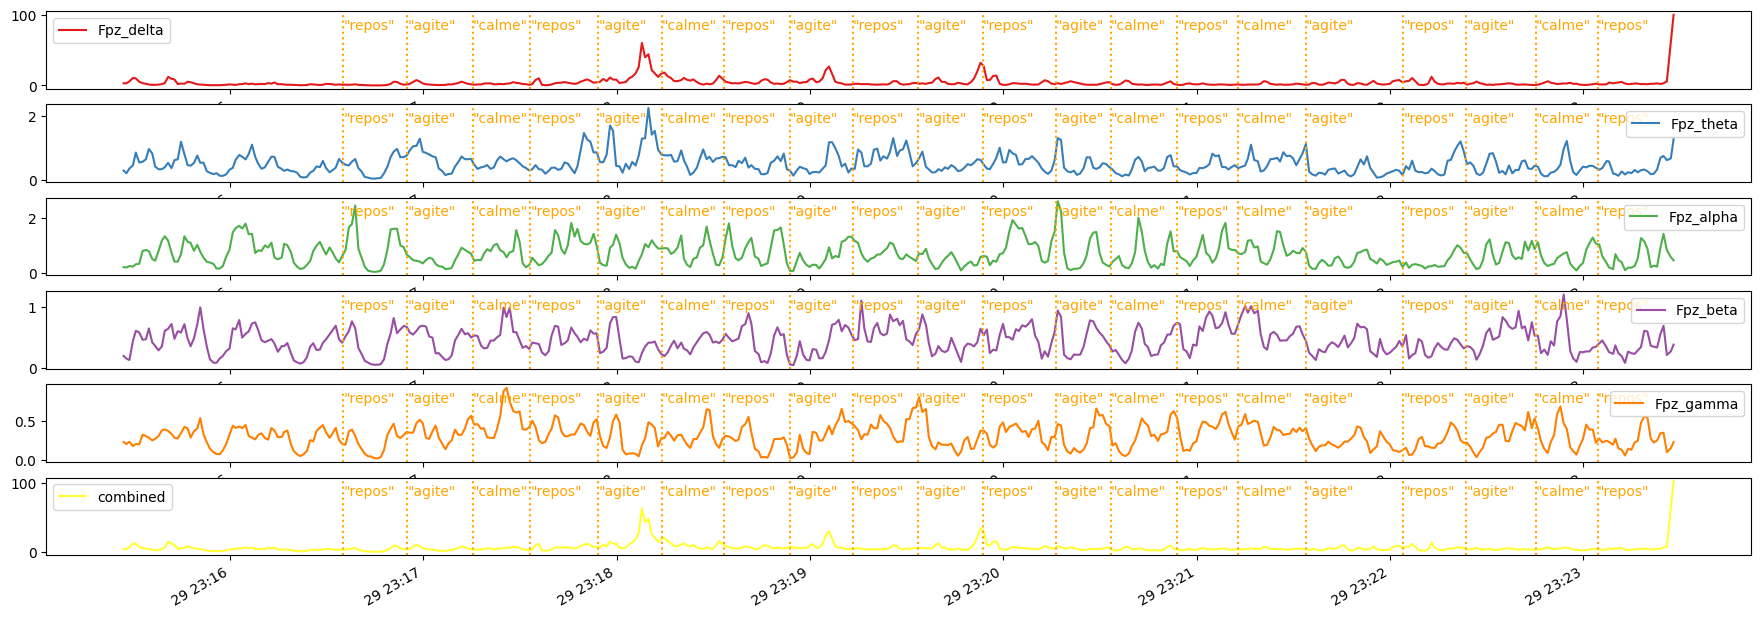

In [6]:
fig, ax = plt.subplots(len(datasets_dic['bands'].keys()), figsize=(22,8))

i = 0
df = datasets_dic['events'].loc[datasets_dic['events'].label=='start']
for k in datasets_dic['bands'].keys():
    datasets_dic['bands'][[k]].plot(ax=ax[i], c=palette[i])
    for idx in df.index:
        ax[i].axvline(idx, 0, datasets_dic['bands'][k].max(), color='orange', linestyle=':')
        ax[i].text(idx, datasets_dic['bands'][k].max()*.8, df.loc[idx].data, color='orange', weight='ultralight')

    i+=1


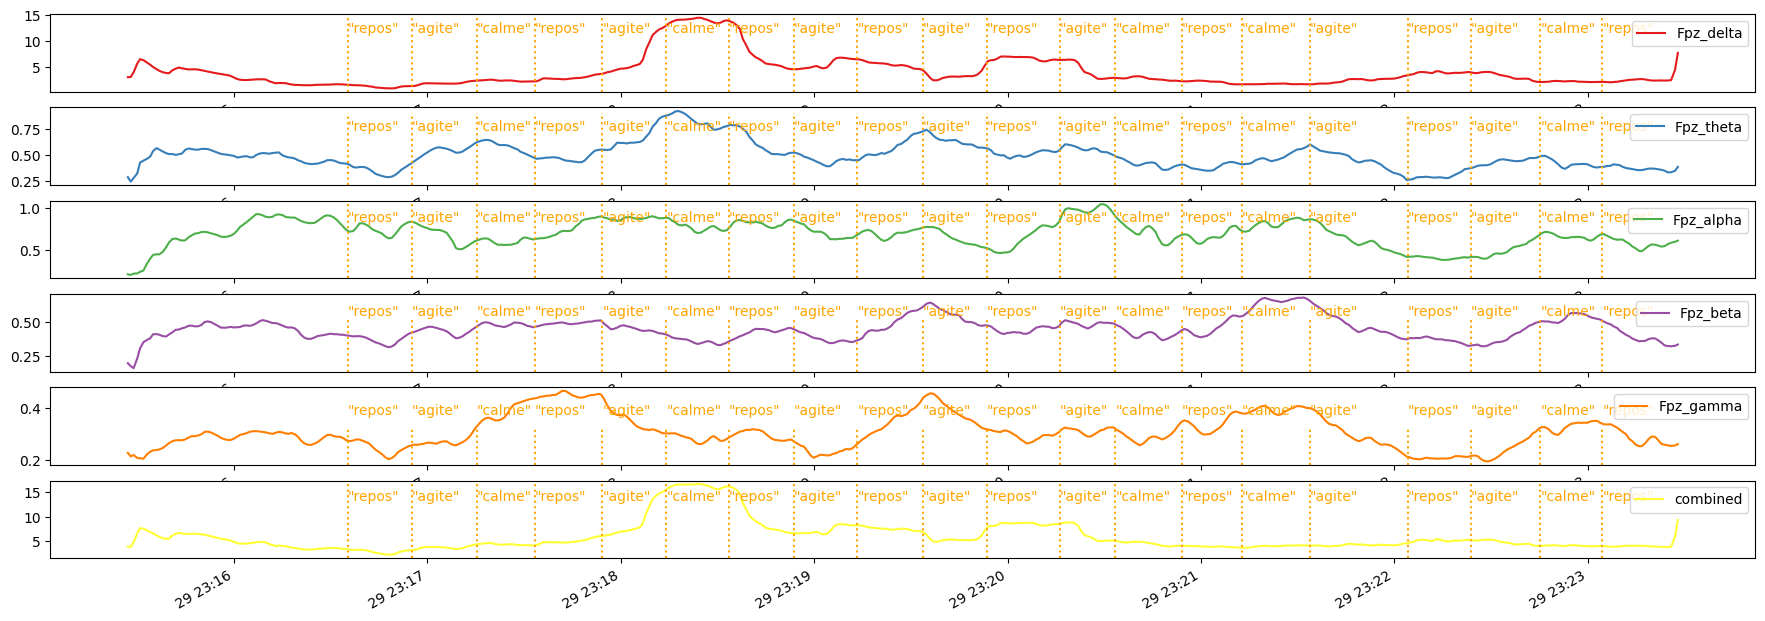

In [7]:
fig, ax = plt.subplots(len(datasets_dic['bands'].keys()), figsize=(22,8))

i = 0
df = datasets_dic['events'].loc[datasets_dic['events'].label=='start']
for k in datasets_dic['bands'].keys():
    tt = datasets_dic['bands'][[k]].rolling(30, min_periods=1).mean()
    tt.plot(ax=ax[i], c=palette[i])
    for idx in df.index:
        ax[i].axvline(idx, 0, tt.max(), color='orange', linestyle=':')
        ax[i].text(idx, tt.max()*.8, df.loc[idx].data, color='orange', weight='ultralight')

    i+=1

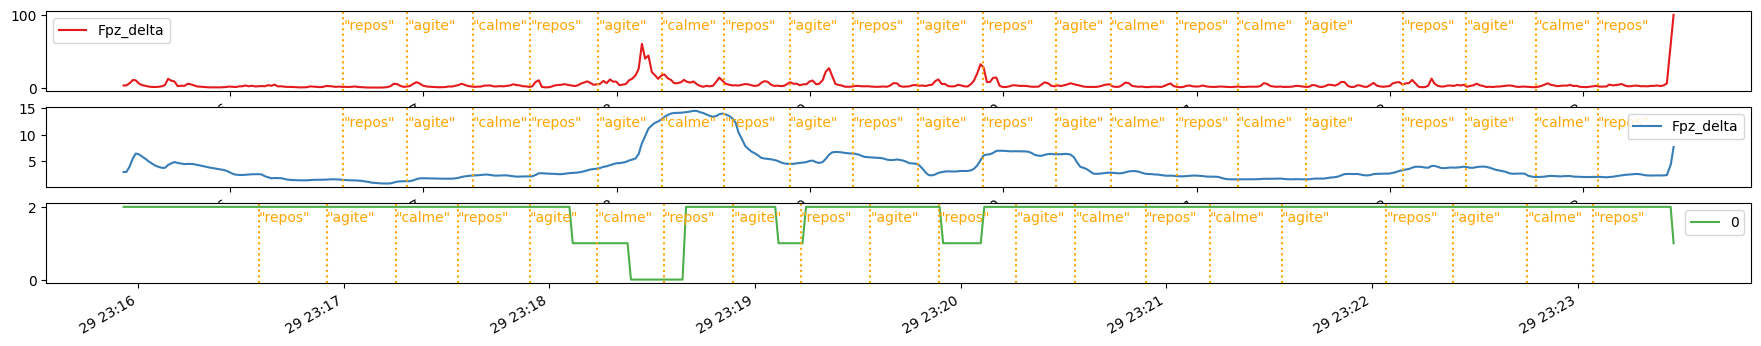

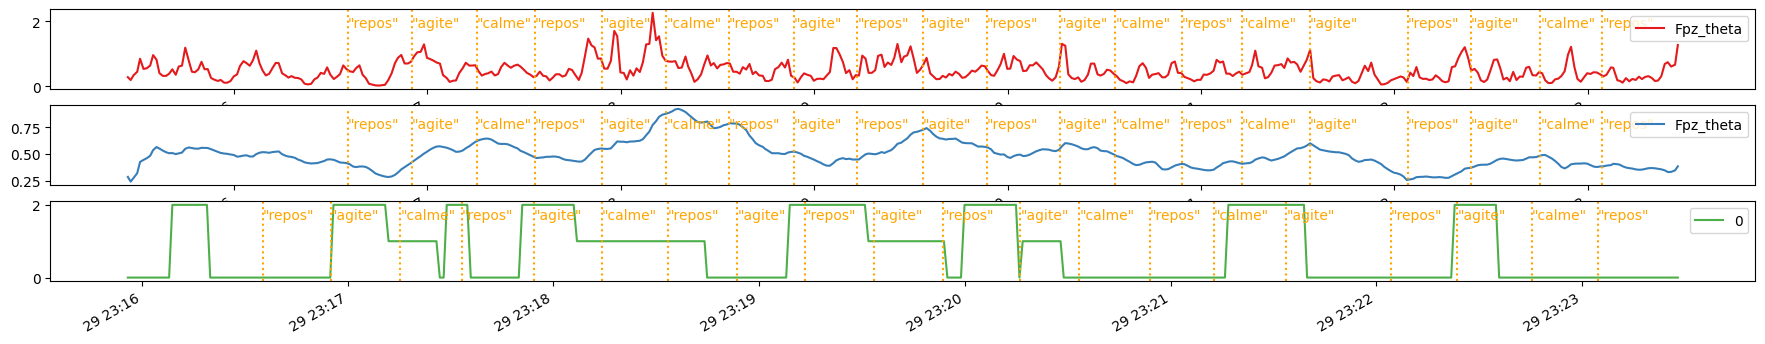

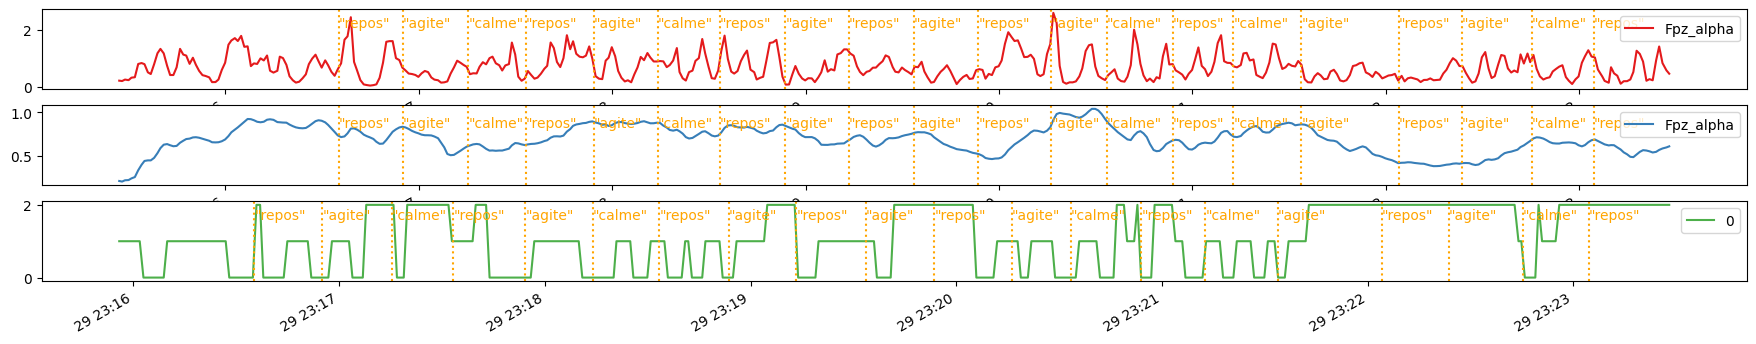

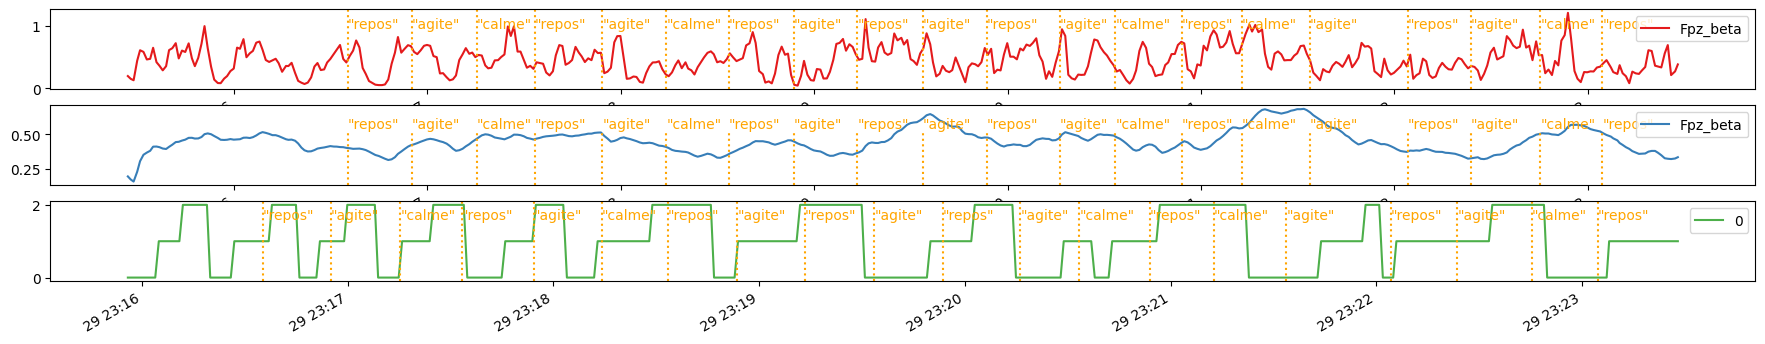

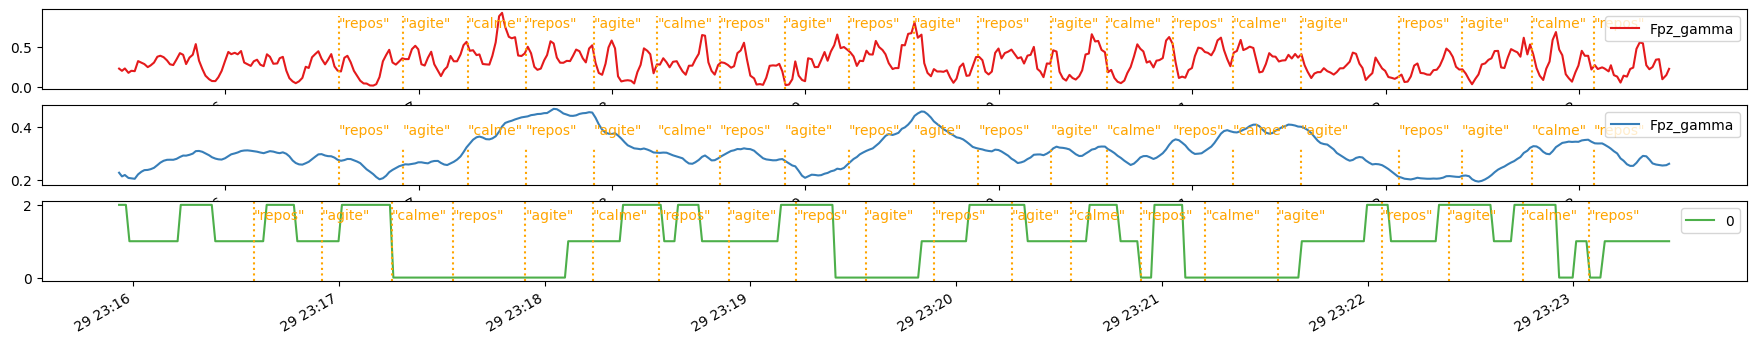

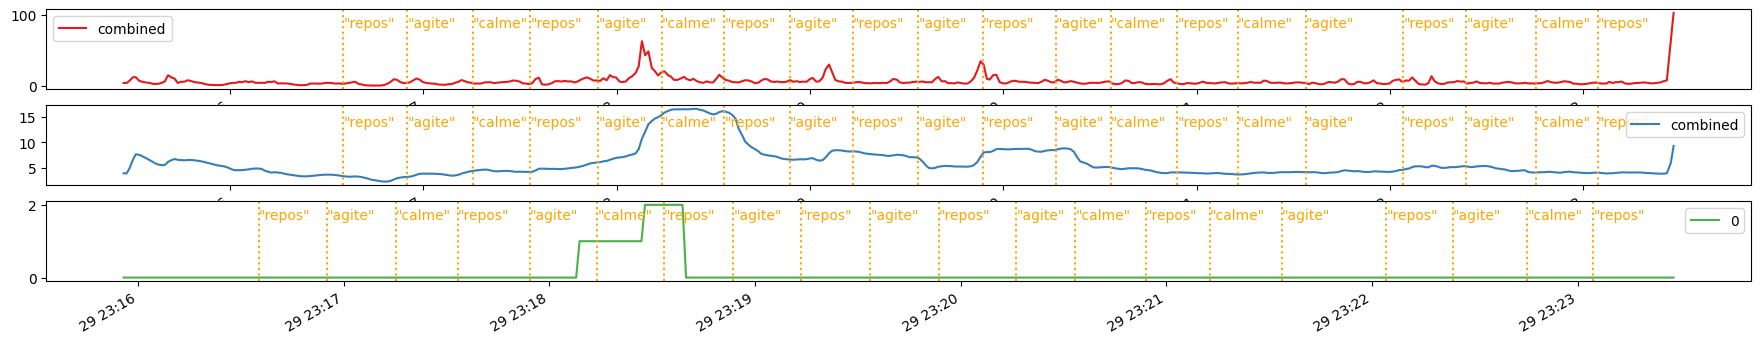

In [9]:
features = ['Fpz_delta','Fpz_theta','Fpz_alpha','Fpz_beta','Fpz_gamma', 'combined']
wid = 30

df_lag = datasets_dic['bands'].copy()
for i in range(1,wid):
    df_lag = df_lag.merge(datasets_dic['bands'].shift(i), how='inner', left_index=True, right_index=True, suffixes=('',f'_{i:02d}'))

scaler = StandardScaler()
for feature in features:
    df_norm = scaler.fit_transform(df_lag[[f for f in df_lag.keys() if feature in f]].dropna())
    km = KMeans(
        n_clusters=3, init='random',
        n_init=20, max_iter=1000, 
        tol=1e-05, random_state=0
    )
    y_km = km.fit_predict(df_norm)
    y_km = pd.DataFrame(y_km, index=df_lag.dropna().index)
    dd = pd.DataFrame(index=datasets_dic['bands'].index)
    dd.loc[dd.index.isin(y_km.index), y_km.keys()] = y_km
    y_km = dd.copy()
    del dd

    fig, ax = plt.subplots(3, figsize=(22,4))

    i = 0
    df = datasets_dic['events'].loc[datasets_dic['events'].label=='start']
    tt = datasets_dic['bands'][[feature]]
    tt.plot(ax=ax[i], c=palette[i])
    for idx in df.index:
        ax[i].axvline(idx, 0, tt.max(), color='orange', linestyle=':')
        ax[i].text(idx, tt.max()*.8, df.loc[idx].data, color='orange', weight='ultralight')
    i+=1
    tt = datasets_dic['bands'][[feature]].rolling(wid, min_periods=1).mean()
    tt.plot(ax=ax[i], c=palette[i])
    for idx in df.index:
        ax[i].axvline(idx, 0, tt.max(), color='orange', linestyle=':')
        ax[i].text(idx, tt.max()*.8, df.loc[idx].data, color='orange', weight='ultralight')
    i+=1
    y_km.plot(ax=ax[i], c=palette[i])
    for idx in df.index:
        ax[i].axvline(idx, 0, y_km.max(), color='orange', linestyle=':')
        ax[i].text(idx, y_km.max()*.8, df.loc[idx].data, color='orange', weight='ultralight')